# CFZ-Net: OCTA Image Segmentation with PyTorch

This GitHub repository hosts the implementation of CFZ-Net, a deep learning model developed in PyTorch for segmenting capillary free zones (CFZ), arteries, and veins in optical coherence tomography angiography (OCTA) images. The model is trained on high-resolution 6x6mm OCTA images, aiming to accurately delineate vascular structures for medical research and diagnosis.

In [ ]:
import os
import random
from shutil import copyfile

import cv2
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchmetrics as TM
import torchvision
import torchvision.transforms as T

from PIL import Image
from torch.utils.data import Dataset, DataLoader

import albumentations as A
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp

In [ ]:
# Predefined transformations for frequent use
Tensor2PILImage = T.ToPILImage()
PILImage2Tensor = T.ToTensor()

In [ ]:
# Classes

CLASSES = ['background', 'vCFZ', 'vein', 'aCFZ', 'artery']

num_of_classes = len(CLASSES)

CLASS_COLORS = [(0, 0, 0), (255, 0, 255), (0, 255, 255), (255, 255, 0), (255, 0, 0)]


In [ ]:
# Create a nested directory structure
parent_dir =   # Please enter the root directory for your project:

Save_folder_name = "CFZ segementation V5T01"
save_path = os.path.join(parent_dir, Save_folder_name)

dataframe_name = 'train_data_tmp_Idea61CFZ.csv'

project_path = os.path.join(parent_dir, 'tmp_Idea61CFZ')
dataset_path = os.path.join(project_path, 'Dataset')
train_path = os.path.join(dataset_path, 'train')
input_path = os.path.join(train_path, 'Input')
output_path = os.path.join(train_path, 'CFZ_map')


try:
    os.mkdir(save_path)
    os.mkdir(project_path)
    os.mkdir(dataset_path)
    os.mkdir(train_path)
    os.mkdir(input_path)
    os.mkdir(output_path)
except OSError:
    pass

In [ ]:
imagesize = 320 # Set the standard image size for resizing images

def Tranfer_data(SOURCE, DESTINATION):
    """Transfers and processes image files."""
    files = []
    for subfolder in os.listdir(SOURCE):
        for filename in os.listdir(os.path.join(SOURCE, subfolder, 'AVA_map')):
            if filename[-11:] == '_CFZ_MM.png':
                file_OCTA = os.path.join(SOURCE, subfolder, 'OCTA', filename[:-11] + '.tiff')
                if not os.path.isfile(file_OCTA):
                    file_OCTA = os.path.join(SOURCE, subfolder, 'OCTA', filename[:-11] + '.png')
                file_CFZ_map = os.path.join(SOURCE, subfolder, 'AVA_map', filename)

                # Define the destination paths
                destination_Input = os.path.join(DESTINATION, 'train/Input', filename[:-5] + '.png')
                destination_Output = os.path.join(DESTINATION, 'train/CFZ_map', filename[:-5] + '.png')

                # Read and resize the OCTA and CFZ map images
                im_OCTA = cv2.imread(file_OCTA, cv2.IMREAD_GRAYSCALE)
                im_CFZ_map = cv2.imread(file_CFZ_map)
                im_OCTA = cv2.resize(im_OCTA, (imagesize, imagesize))
                im_CFZ_map = cv2.resize(im_CFZ_map, (imagesize, imagesize))

                # Normalize OCTA images to 0-255 scale
                im_OCTA = np.array(im_OCTA, dtype=np.float32)
                im_CFZ_map = np.array(im_CFZ_map, dtype=np.float32)
                im_OCTA = 255.0 * (im_OCTA - np.min(im_OCTA)) / (np.max(im_OCTA) - np.min(im_OCTA))

                # Convert grayscale image to 3-channel
                im_OCTA_3chs = cv2.merge([im_OCTA, im_OCTA, im_OCTA])

                # Save the processed images
                cv2.imwrite(destination_Input, im_OCTA_3chs.astype(np.uint8))
                cv2.imwrite(destination_Output, im_CFZ_map.astype(np.uint8))

                files.append(filename)

    files = list(set(files))
    return files


SOURCE_DIR = "D:\\AV Project\\Dataset6x6mm\\"
DESTINATION_DIR = dataset_path


filenames = Tranfer_data(SOURCE_DIR, DESTINATION_DIR)

In [ ]:
# Create the DataFrame and save to CSV
dframe1 = pd.DataFrame({'Input' : filenames, 'CFZ' : filenames})
dframe1.to_csv(os.path.join(parent_dir, dataframe_name), index=False)
dframe1.head()

In [ ]:
def get_device():
    """Return the appropriate device (CUDA or CPU) based on availability."""
    return torch.device("cuda" if torch.cuda.is_available() else "cpu")


def to_device(x):
    """Send the tensor or model to the appropriate device."""
    device = get_device()
    return x.to(device)


def get_model_parameters(model):
    return sum(param.numel() for param in model.parameters())


print(f"CUDA: {torch.cuda.is_available()}")

CUDA: True


In [ ]:
def set_class_values(all_classes, classes_to_train):
    """Assigns a specific class label to each of the classes."""

    class_indices = {cls.lower(): idx for idx, cls in enumerate(all_classes)}
    class_values = [class_indices[cls.lower()] for cls in classes_to_train]

    return class_values


def get_label_mask(mask, class_values, label_colors_list):
    """Encodes image pixels into class-specific labels."""

    mask = np.array(mask)
    label_colors = np.array(label_colors_list)

    # Initializing the label mask
    label_mask = np.zeros((mask.shape[0], mask.shape[1], 1), dtype=int)

    # Iterate over each class and update the label mask
    for value, color in enumerate(label_colors):
        if value in class_values:
            # Compare mask with class color and update label_mask
            matches = np.all(mask == color, axis=-1)
            label_mask[matches] = value

    return label_mask


def load_image_paths(df, path, column):
    """Lists image paths."""
    images = []
    for i, item in df.iterrows():
        temp_item =  os.path.join(path , item[column])
        images.append(temp_item)
    return images



def get_images(parent_dir, fold_num = 1, max_fold = 5):
    """Loads paths for training and validation images and masks based on the fold."""
    # Define paths
    train_csv_path = os.path.join(parent_dir, dataframe_name)
    image_dir = input_path
    mask_dir = output_path

    # Read the data CSV
    df = pd.read_csv(train_csv_path)

    # Calculate the indices for training and validation splits
    num_samples = len(df)
    start_val = int((fold_num - 1) / max_fold * num_samples)
    end_val = int(fold_num / max_fold * num_samples)

    # Create training and validation subsets
    df_train = pd.concat([df[:start_val], df[end_val:]], ignore_index=True)
    df_val = df[start_val:end_val]

    # Load image and mask paths
    train_images = load_image_paths(df_train, image_dir, 0)
    train_masks = load_image_paths(df_train, mask_dir, 1)
    valid_images = load_image_paths(df_val, image_dir, 0)
    valid_masks = load_image_paths(df_val, mask_dir, 1)

    return train_images, train_masks, valid_images, valid_masks


def train_transforms(img_size):
    """Transforms/augmentations for training images and masks."""
    train_image_transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.Affine(shear=0.4, mode=4, p=0.3),
        A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.2, p=1.0),
        A.ShiftScaleRotate(scale_limit=0.3, rotate_limit=50, shift_limit=0.3, p=1.0),
        A.PadIfNeeded(min_height=img_size, min_width=img_size, always_apply=True),
        A.Blur(blur_limit=3, p=0.2),
    ])
    return train_image_transform


def valid_transforms(img_size):
    """Transforms/augmentations for validation images and masks."""
    return A.Compose([A.Resize(img_size, img_size, always_apply=True)])


class SegmentationDataset(Dataset):
    def __init__(self, image_paths, mask_paths, tfms, label_colors_list, classes_to_train, all_classes):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.tfms = tfms
        self.label_colors_list = label_colors_list
        self.all_classes = all_classes
        self.classes_to_train = classes_to_train
        # Convert string names to class values for masks.
        self.class_values = set_class_values(
            self.all_classes, self.classes_to_train
        )

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        # Load the image and mask
        image = cv2.imread(self.image_paths[index], cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype('float32')
        image = image / 255.0
        mask = cv2.imread(self.mask_paths[index], cv2.IMREAD_COLOR)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB).astype('float32')

        # Apply transformations
        transformed = self.tfms(image=image, mask=mask)
        image = transformed['image']
        mask = transformed['mask']

        # Get colored label mask.
        mask = get_label_mask(mask, self.class_values, self.label_colors_list)

        # Convert to tensors
        image = torch.from_numpy(np.transpose(image, (2, 0, 1))).float()
        mask = torch.from_numpy(np.transpose(mask, (2, 0, 1))).long()

        return image, mask

In [ ]:
# Define constants for training
classes_to_train = CLASSES
batch_size = 15
fold_num = 1
max_fold = 5

# Load images and masks
train_images, train_masks, valid_images, valid_masks = get_images(parent_dir, fold_num = 1, max_fold = 5)

# Set up transformations
train_tfms = train_transforms(imagesize)
valid_tfms = valid_transforms(imagesize)

# Initialize datasets
train_dataset = SegmentationDataset(train_images, train_masks, train_tfms,
    CLASS_COLORS, classes_to_train, CLASSES)
valid_dataset = SegmentationDataset(valid_images, valid_masks, valid_tfms,
    CLASS_COLORS, classes_to_train, CLASSES)

# Configure data loaders
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, drop_last=False)
valid_data_loader = DataLoader(valid_dataset, batch_size=batch_size, drop_last=False)

# Access a batch of data
(train_data_inputs, train_data_targets) = next(iter(train_data_loader))
(valid_data_inputs, valid_data_targets) = next(iter(valid_data_loader))
print(train_data_inputs.shape, train_data_targets.shape, train_data_inputs.dtype, train_data_targets.dtype)

torch.Size([15, 3, 320, 320]) torch.Size([15, 1, 320, 320]) torch.float32 torch.int64


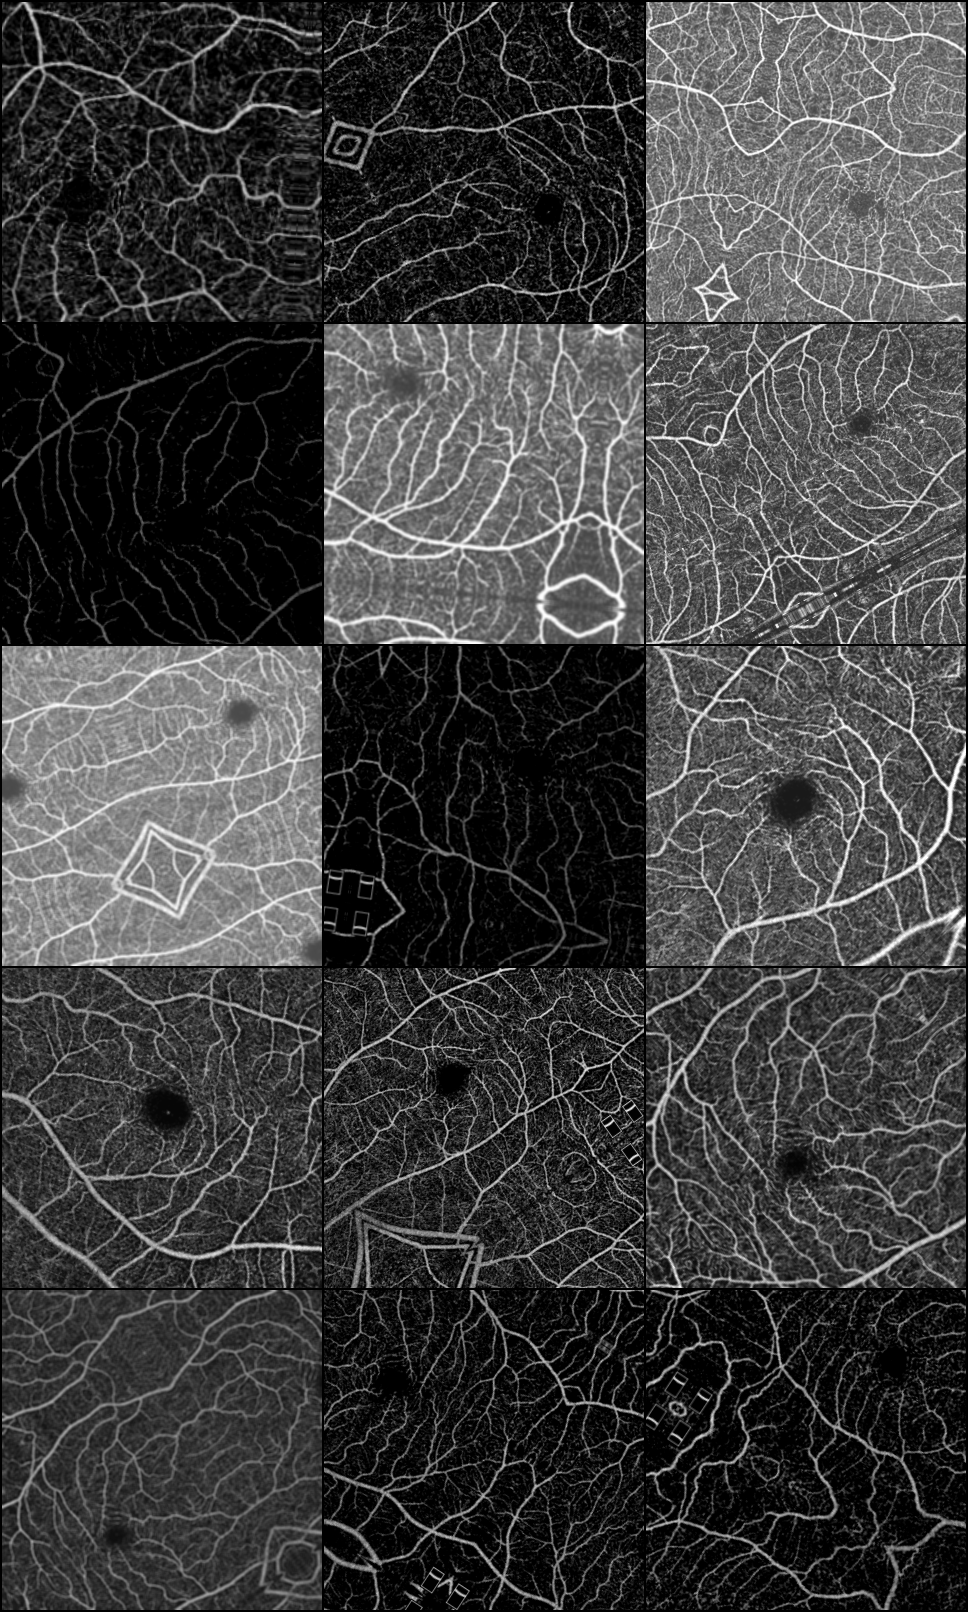

In [ ]:
# Create a grid of input images
data_input_grid = torchvision.utils.make_grid(train_data_inputs, nrow=3)
# Convert the tensor to a PIL Image
Tensor2PILImage(data_input_grid)

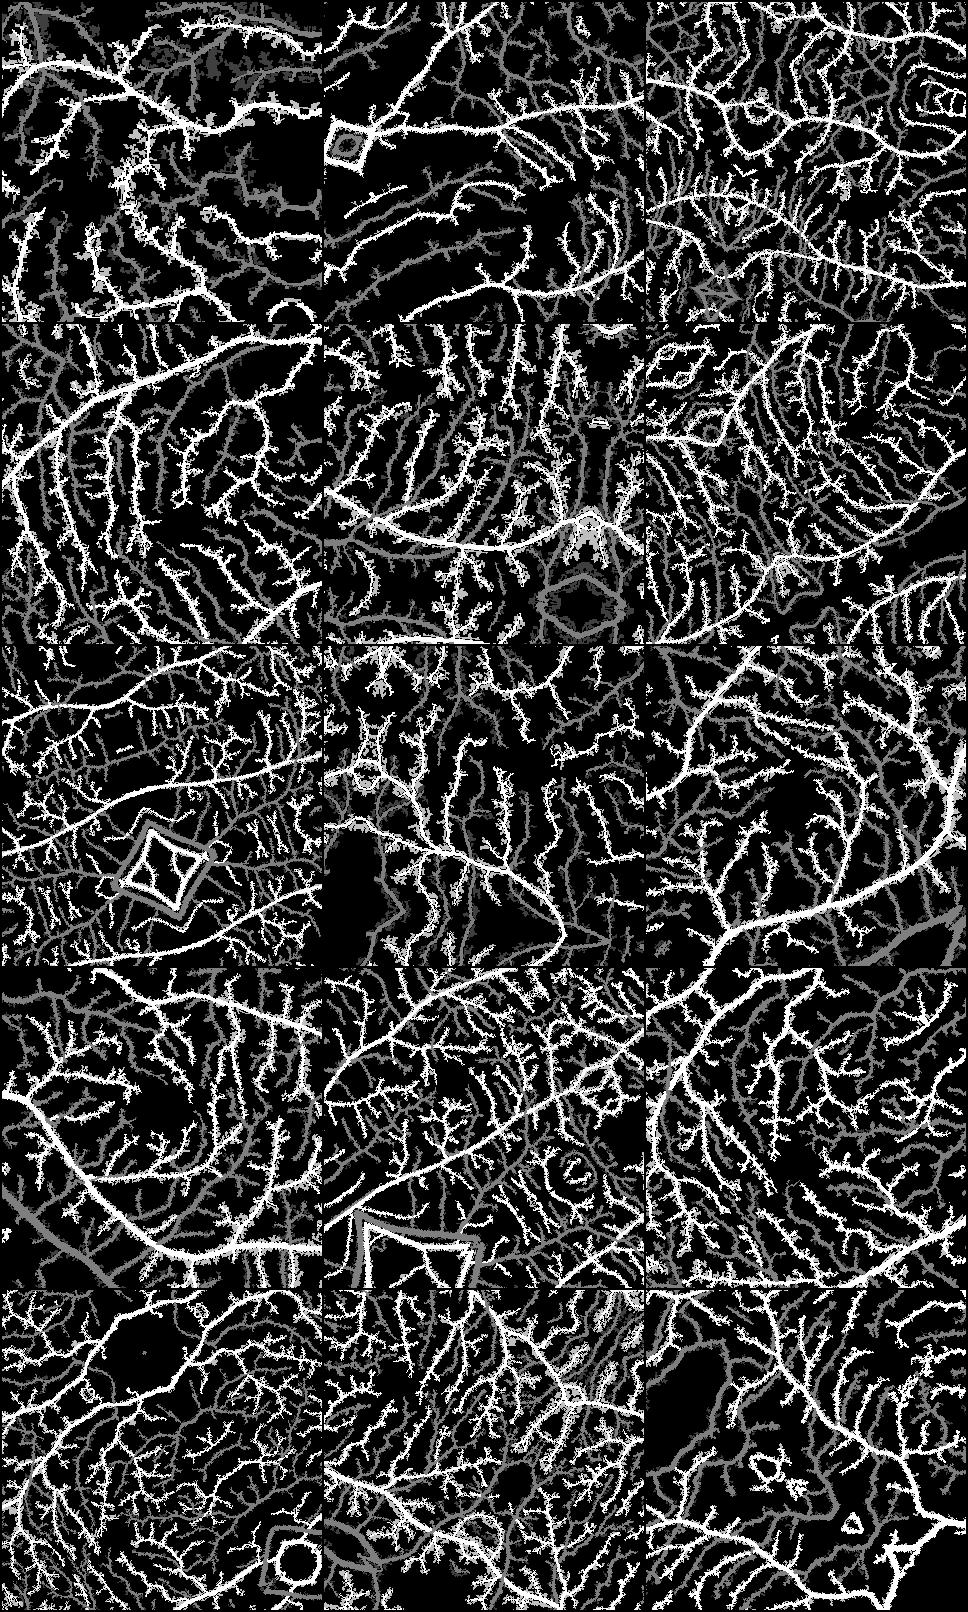

In [ ]:
# Create a grid of output images
data_targets_grid = torchvision.utils.make_grid(train_data_targets / 4.0, nrow=3)
# Convert the tensor to a PIL Image
Tensor2PILImage(data_targets_grid)

In [ ]:
# Initialize the model and move it to the defined device
model = smp.Unet("efficientnet-b7", encoder_weights='imagenet', classes=len(classes_to_train))
to_device(model)

# Perform a forward pass and check the output shape
print(model(to_device(train_data_inputs)).shape)

torch.Size([15, 5, 320, 320])


In [ ]:
def IoUMetric(pred, gt, softmax=False):
    """Calculate the mean Intersection over Union (IoU)."""
    # Run softmax if input is logits.
    if softmax is True:
        pred = nn.Softmax(dim=1)(pred)

    # One-hot encoding of ground truth
    gt = F.one_hot(gt.squeeze(1), num_classes=num_of_classes).permute(0, 3, 1, 2).float()

    # Computation of intersection and union
    intersection = torch.sum(gt * pred, dim=(2, 3))
    union = torch.sum(pred + gt, dim=(2, 3)) - intersection

    # Smoothed IoU calculation
    iou = (intersection + 0.001) / (union + 0.001)

    # Return the mean IoU
    return iou.mean()



class IoULoss(nn.Module):
    def __init__(self, softmax=False):
        super().__init__()
        self.softmax = softmax

    def forward(self, pred, gt):
        # Convert IoU score to a loss value
        return -torch.log(IoUMetric(pred, gt, self.softmax))



In [ ]:
def train_model(model, loader, optimizer, use_cel=False):
    """Trains the model using a specified data loader and optimizer."""
    to_device(model.train())

    if use_cel:
        criterion = nn.CrossEntropyLoss(reduction='mean')
    else:
        criterion = IoULoss(softmax=True)

    running_loss = 0.0
    running_samples = 0

    for inputs, targets in loader:
        inputs, targets = to_device(inputs), to_device(targets)
        optimizer.zero_grad()
        outputs = model(inputs)

        if use_cel:
            targets = targets.squeeze(dim=1)

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_samples += inputs.size(0)
        running_loss += loss.item() * inputs.size(0)

    return running_loss / running_samples

In [ ]:
def calculate_metrics(model, loader, use_cel=False):
    """Calculates different metrics during training."""
    if use_cel:
        criterion = nn.CrossEntropyLoss(reduction='mean')
    else:
        criterion = IoULoss(softmax=True)

    to_device(model.eval())
    f1score = to_device(TM.classification.MulticlassF1Score(num_of_classes, average='micro'))
    pixel_metric = to_device(TM.classification.MulticlassAccuracy(num_of_classes, average='micro'))

    f1_scores = []
    pixel_accuracies = []
    iou_accuracies = []
    running_loss = 0.0
    running_samples = 0

    for inputs, targets in loader:
        inputs = to_device(inputs)
        targets = to_device(targets)
        predictions = model(inputs)

        if use_cel:
            targets = targets.squeeze(dim=1)

        loss = criterion(predictions, targets)
        running_samples += inputs.size(0)
        running_loss += loss.item() * inputs.size(0)

        pred_probabilities = nn.Softmax(dim=1)(predictions)
        pred_labels = predictions.argmax(dim=1)

        pred_labels = pred_labels.unsqueeze(1)
        pred_mask = pred_labels.to(torch.float)

        f1_score = f1score(pred_mask, targets)
        pixel_accuracy = pixel_metric(pred_labels, targets)
        iou = IoUMetric(pred_probabilities, targets)

        f1_scores.append(f1_score.item())
        pixel_accuracies.append(pixel_accuracy.item())
        iou_accuracies.append(iou.item())

    f1_score_tensor = torch.FloatTensor(f1_scores)
    accuracy_tensor = torch.FloatTensor(pixel_accuracies)
    iou_tensor = torch.FloatTensor(iou_accuracies)

    return running_loss/running_samples, accuracy_tensor.mean().item(), iou_tensor.mean().item(), f1_score_tensor.mean().item()

In [ ]:
def plot_metric(x, y, xlabel, ylabel, title, save_path, filename):
    """Helper function to plot and save a metric."""
    plt.figure(figsize=(10, 7), facecolor='white')
    plt.plot(x, color='tab:blue', linestyle='-', label=f'train {ylabel}')
    plt.plot(y, color='tab:red', linestyle='-', label=f'validation {ylabel}')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.savefig(os.path.join(save_path, filename))


def learning_plots(train_acc, val_acc, train_loss, val_loss, train_iou, valid_iou, save_path):
    """Function to save the loss, accuracy, and IoU plots to disk."""

    plot_metric(train_acc, val_acc, 'Epochs', 'accuracy', 'Training vs Validation Accuracy', save_path, 'accuracy.png')

    plot_metric(train_loss, val_loss, 'Epochs', 'loss', 'Training vs Validation Loss', save_path, 'loss.png')

    plot_metric(train_iou, valid_iou, 'Epochs', 'IoU', 'Training vs Validation mIoU', save_path, 'iou.png')


In [ ]:
def train_loop(model, train_loader, valid_loader, epochs, optimizer, scheduler, save_path, use_cel = False):
    """Trains the model over specified epochs, evaluates performance metrics, and saves the trained model."""

    train_loss_list, train_acc_list, train_iou_list, train_f1_list = [], [], [], []
    val_loss_list, val_acc_list, val_iou_list, val_f1_list = [], [], [], []
    for epoch in range(1, epochs + 1):
        loss = train_model(model, train_loader, optimizer, use_cel=use_cel)
        with torch.inference_mode():
            train_loss, train_acc, train_iou, train_f1 = calculate_metrics(model, train_loader, use_cel=use_cel)
            val_loss, val_acc, val_iou, val_f1 = calculate_metrics(model, valid_loader, use_cel=use_cel)

        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)
        train_iou_list.append(train_iou)
        train_f1_list.append(train_f1)
        val_loss_list.append(val_loss)
        val_acc_list.append(val_acc)
        val_iou_list.append(val_iou)
        val_f1_list.append(val_f1)


        print(f"Epoch: {epoch:04d}, LR: {optimizer.param_groups[0]['lr']:.5f}, Training: (Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, F1: {train_f1:.4f}, IoU: {train_iou:.4f}), " +
        f"Valication: (Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, F1: {val_f1:.4f}, IoU: {val_iou:.4f})")

        if scheduler is not None:
            scheduler.step()


    torch.save(model.state_dict(), os.path.join(save_path, f"Trained_model.pth"))
    learning_plots(train_acc_list, val_acc_list, train_loss_list, val_loss_list, train_iou_list, val_iou_list, save_path)


Epoch: 0001, LR: 0.00100, Training: (Loss: 2.5799, Acc: 0.1230, F1: 0.1230, IoU: 0.0758), Valication: (Loss: 2.5274, Acc: 0.1270, F1: 0.1270, IoU: 0.0799)
Epoch: 0002, LR: 0.00100, Training: (Loss: 2.2657, Acc: 0.2805, F1: 0.2805, IoU: 0.1038), Valication: (Loss: 2.2198, Acc: 0.2938, F1: 0.2938, IoU: 0.1086)
Epoch: 0003, LR: 0.00100, Training: (Loss: 1.8768, Acc: 0.5391, F1: 0.5391, IoU: 0.1531), Valication: (Loss: 1.9152, Acc: 0.4992, F1: 0.4992, IoU: 0.1473)
Epoch: 0004, LR: 0.00100, Training: (Loss: 1.7207, Acc: 0.5919, F1: 0.5919, IoU: 0.1789), Valication: (Loss: 1.6980, Acc: 0.5900, F1: 0.5900, IoU: 0.1830)
Epoch: 0005, LR: 0.00100, Training: (Loss: 1.4918, Acc: 0.7060, F1: 0.7060, IoU: 0.2250), Valication: (Loss: 1.4477, Acc: 0.7091, F1: 0.7091, IoU: 0.2351)
Epoch: 0006, LR: 0.00100, Training: (Loss: 1.4238, Acc: 0.6906, F1: 0.6906, IoU: 0.2408), Valication: (Loss: 1.3656, Acc: 0.6953, F1: 0.6953, IoU: 0.2552)
Epoch: 0007, LR: 0.00100, Training: (Loss: 1.3384, Acc: 0.7118, F1: 0.

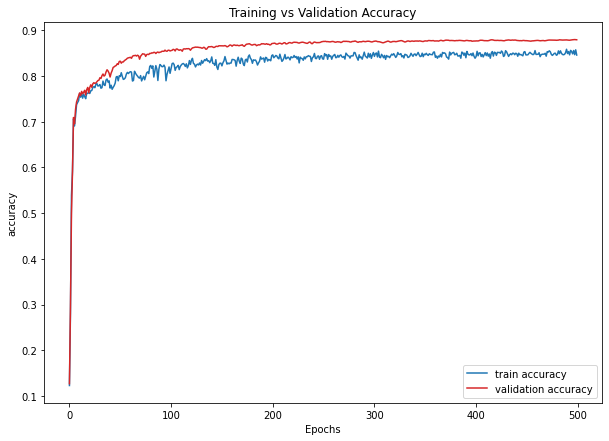

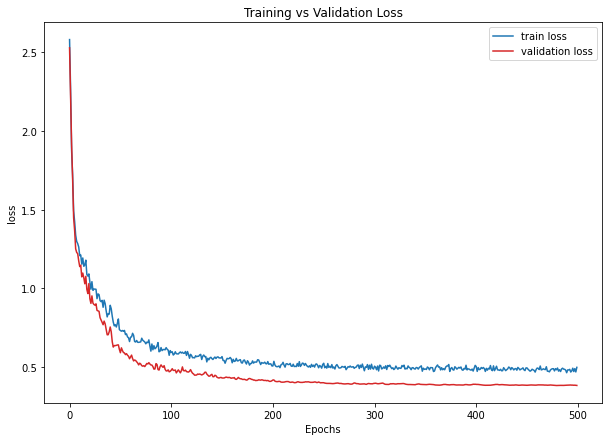

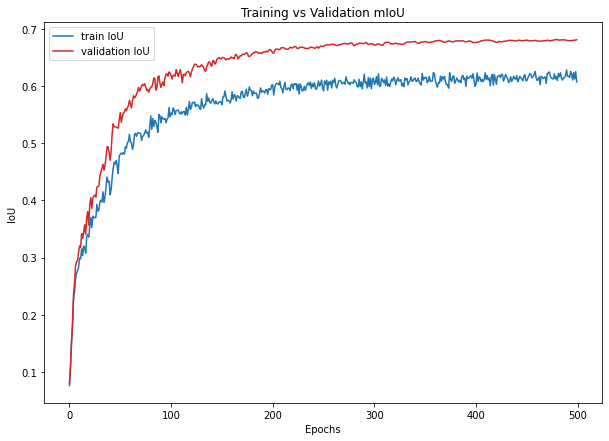

In [ ]:
# Optimizer and Learning Rate Scheduler.
to_device(model)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.7)
epochs = 500

train_loop(model, train_data_loader, valid_data_loader, epochs, optimizer, scheduler, save_path)

In [ ]:
def inv_segmentation_map(outputs):
    """Converts model output tensors into a segmentation map."""
    labels = torch.argmax(outputs.squeeze(), dim=0).detach().cpu().numpy()
    class_colors = np.array(CLASS_COLORS)

    # Create the segmentation map by indexing directly into class_colors
    segmentation_map = class_colors[labels]

    return segmentation_map

def make_predictions(filename, INPUT_DIR, OUTPUT_DIR):
    """Processes OCTA images to predict segmentation maps, evaluate model performance metrics, and visualize the results."""
    file_OCTA = os.path.join(INPUT_DIR, filename)
    file_CFZ_map = os.path.join(OUTPUT_DIR, filename)
    im_OCTA = Image.open(file_OCTA)
    im_CFZ_map = Image.open(file_CFZ_map)
    im_CFZ_inv = im_CFZ_map
    im_OCTA = PILImage2Tensor(im_OCTA)
    im_OCTA = im_OCTA.unsqueeze(0)
    im_CFZ_map = np.array(im_CFZ_map)

    class_values = set_class_values(CLASSES, CLASSES)
    im_CFZ_map = get_label_mask(im_CFZ_map, class_values, CLASS_COLORS)
    im_CFZ_map = torch.nn.functional.one_hot(torch.tensor(im_CFZ_map, dtype=torch.long)).permute(2, 3, 0, 1)

    # Model predictions and evaluations
    pred = model(to_device(im_OCTA))
    impred = nn.Softmax(dim=1)(pred)

    tp, fp, fn, tn = smp.metrics.get_stats(impred, to_device(im_CFZ_map), mode='multilabel', threshold=0.5)
    iou_score_smp = smp.metrics.iou_score(tp, fp, fn, tn, reduction="macro").item()
    iou_score_smp_N = smp.metrics.iou_score(tp, fp, fn, tn, reduction=None)
    f1_score_smp = smp.metrics.f1_score(tp, fp, fn, tn, reduction="macro").item()
    accuracy_smp = smp.metrics.accuracy(tp, fp, fn, tn, reduction="macro").item()
    accuracy_smp_N = smp.metrics.accuracy(tp, fp, fn, tn, reduction=None)

    iou_perclass_smp = iou_score_smp_N.tolist()[0]
    accuracy_perclass_smp = accuracy_smp_N.tolist()[0]

    impredinv = inv_segmentation_map(impred)

    plt.figure(figsize=(35, 35)).patch.set_facecolor('white')
    display_list = [Tensor2PILImage(im_OCTA.squeeze()), im_CFZ_inv, impredinv]
    titles=['OCTA', 'Ground Truth', 'Predicted\nAcc= '+str(np.around(accuracy_smp,4))+', meanIOU= '+str(np.around(iou_score_smp,4))+', IOU coef per class = '+str(np.around(iou_perclass_smp,4))]
    cmaps = ['gray', 'viridis', 'viridis']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(titles[i])
        plt.xticks([])
        plt.yticks([])
        img_arr = display_list[i]
        plt.imshow(img_arr, cmap=cmaps[i], vmin=0, vmax=255)

    return impred

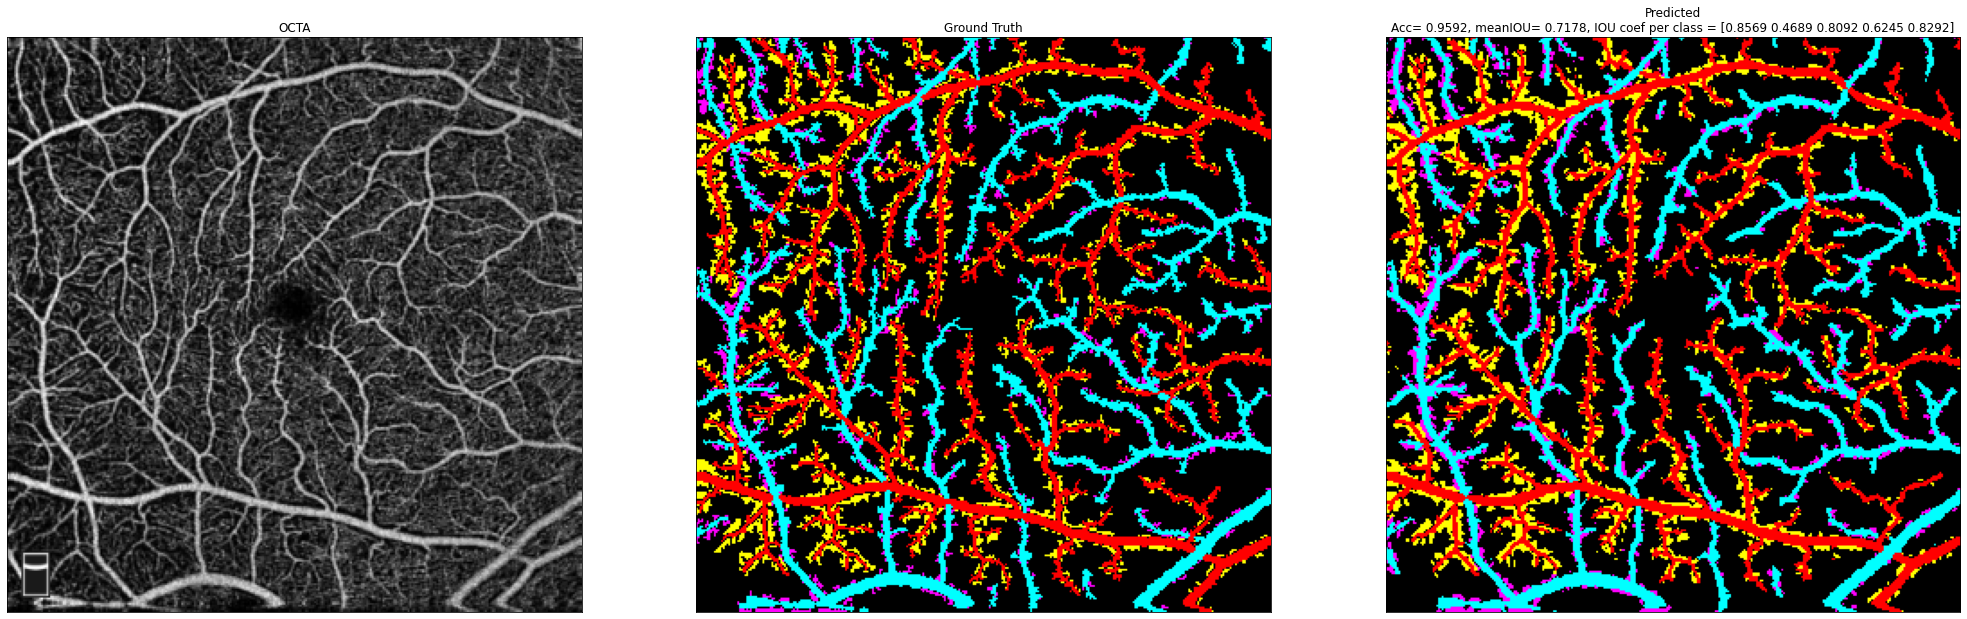

In [ ]:
# Sample fron training dataset
filename = random.sample(train_images, 1)[0].split('\\')[-1]

INPUT_DIR = input_path
OUTPUT_DIR = output_path

impred = make_predictions(filename, INPUT_DIR, OUTPUT_DIR)

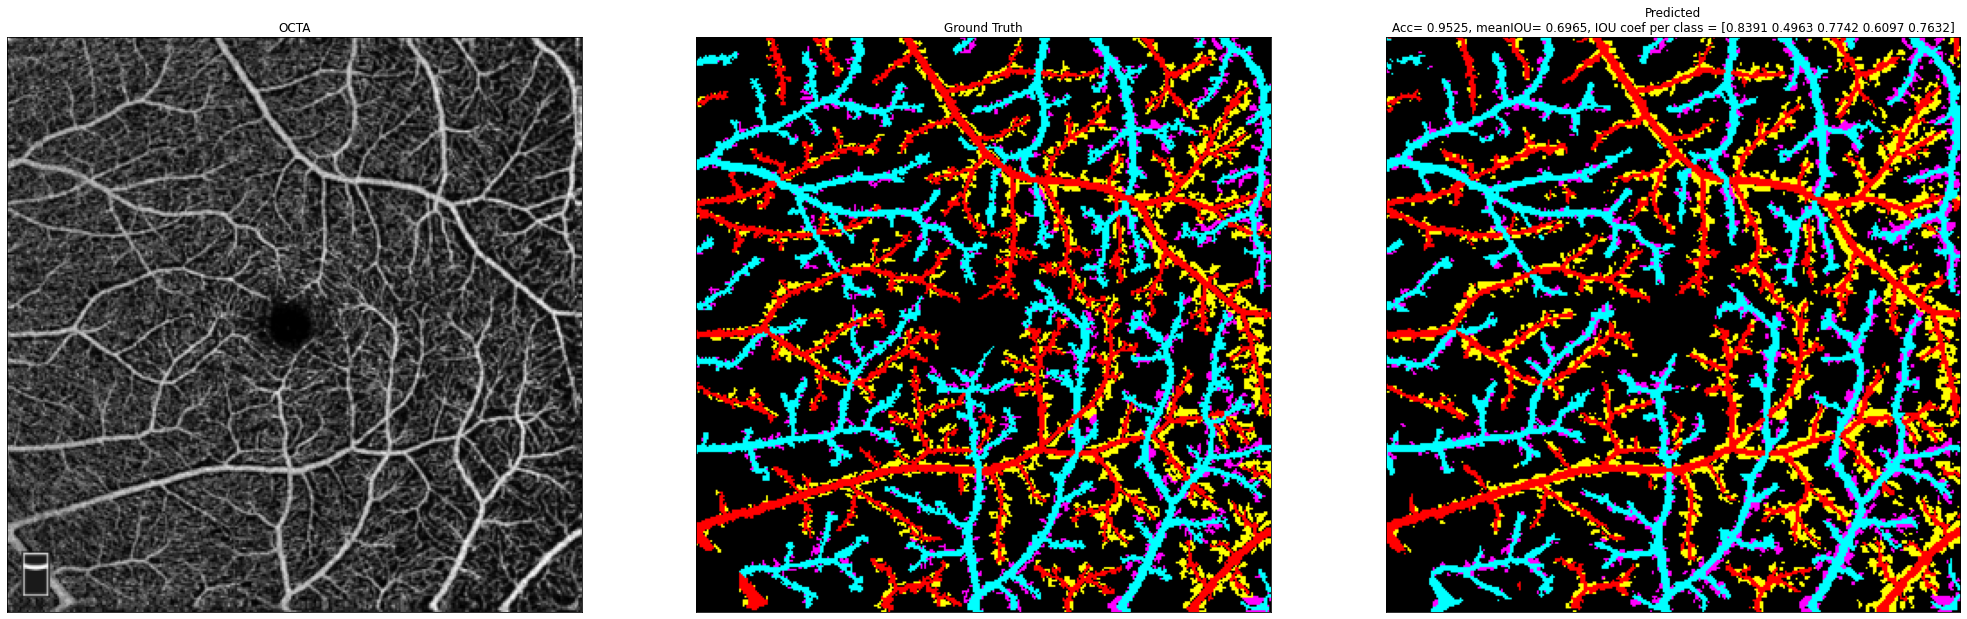

In [ ]:
# Sample fron validation dataset
filename = random.sample(valid_images, 1)[0].split('\\')[-1]

INPUT_DIR = input_path
OUTPUT_DIR = output_path

impred = make_predictions(filename, INPUT_DIR, OUTPUT_DIR)